In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#import des données
sbdata = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv", encoding= "unicode_escape")
sbdata.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


Premier traitement des données

Traitement Des Données Brut, juste pour les rendres utilisables.

In [ ]:
#copie les données
df = pd.DataFrame(sbdata.copy())

#transforme holiday et functioning day en binaire
df['Holiday'] = [1 if x=='Holiday' else 0 for x in df['Holiday'] ]
df['Functioning Day'] = [1 if x=='Yes' else 0 for x in df['Functioning Day'] ]

#divise seasons en 4 colonnes binaires pour chaque saisons
seasons = pd.get_dummies(df['Seasons'])
df = df.drop('Seasons', axis=1)
df = pd.concat([df, seasons], axis=1)

#convertit la date en valeur numérique
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].map(dt.datetime.toordinal)

df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,Autumn,Spring,Summer,Winter
0,736341,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,1,0,0,0,1
1,736341,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,1,0,0,0,1
2,736341,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,1,0,0,0,1
3,736341,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,1,0,0,0,1
4,736341,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,1,0,0,0,1


In [ ]:
#Choix des colonnes
X = np.concatenate((df.iloc[:, [0]].values, df.iloc[:, 2:].values), axis=1)
Y = df.iloc[:, [1]].values

#Séparation du dataset en entrainement et en test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

array([[736341],
       [736341],
       [736341],
       ...,
       [737028],
       [737028],
       [737028]])

In [ ]:
#Mise à l'échelle
from sklearn.preprocessing import StandardScaler
sc =  StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Première régression linéaire

In [ ]:
# Fit regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, Y_train)
lr.coef_

# Predict
Y_prediction = lr.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.5473184289106814
mean_sqrd_error is== 188817.89486509844
root_mean_squared error of is== 434.53181110834504


Premier regression tree

In [ ]:
# Fit regression model
regr = DecisionTreeRegressor(max_depth=10)
regr.fit(X_train, Y_train)

# Predict
Y_prediction = regr.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.8036434107334396
mean_sqrd_error is== 81902.24695691736
root_mean_squared error of is== 286.18568614960003


Deuxième traitement des données

Traitement de données avec la prise en compte du lag. Pour chaque observation on lui attribut les valeurs des 168h précédentes (cad 1 semaine). De plus on choisit de prendre le début de journée à 6h, la nuit étant la fin de la journée précédente.

In [ ]:
df = pd.DataFrame(sbdata.copy())

#change le format de la date et la passe en index
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace = True)
df.rename(columns={'Rented Bike Count': 'Y'}, inplace=True)

#on commence la dataset au premier lundi
df = df[datetime(2017,12,4):datetime(2017,12,4)+timedelta(7*4*7)]
#on ajoute du lag pour dépendre des heures précédentes
for i in range(6, 7*24):
    df["lag_{}".format(i)] = df['Y'].shift(i)

df['Holiday'] = [1 if x=='Holiday' else 0 for x in df['Holiday'] ]
df['Functioning Day'] = [1 if x=='Yes' else 0 for x in df['Functioning Day'] ]
df['Weekday'] = pd.Categorical(pd.Series(df.index).dt.day_name(), categories=['Monday', 'Tuesday', 
             'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Weekend'] = (df['Weekday'].cat.codes >= 5).astype(int)
#df['Hour'] = pd.Series(pd.Series(df.index).dt.hour.values, index= df.index)

#les données temporelles sont des données cycliques, on peut donc les insérer avec leur sin et cos
df['Hour_sin'] = np.sin(df['Hour']*(2.*np.pi/24))
df['Hour_cos'] = np.cos(df['Hour']*(2.*np.pi/24))
df['Weekday_sin'] = np.sin(df['Weekday'].cat.codes*(2.*np.pi/7))
df['Weekday_cos'] = np.cos(df['Weekday'].cat.codes*(2.*np.pi/7))
df.drop(['Hour', 'Seasons', 'Weekday'], axis=1, inplace=True)

#on enlève la première semaine pour éviter les NaN des lags
df = df.iloc[24*7:]
df.head()

,Y,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,...,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,Weekend,Hour_sin,Hour_cos,Weekday_sin,Weekday_cos
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-12-11,125,-2.5,39,3.4,2000,-14.5,0.0,0.0,0.0,0,1,210.0,226.0,214.0,180.0,235.0,182.0,119.0,58.0,19.0,31.0,35.0,20.0,9.0,13.0,71.0,169.0,243.0,280.0,326.0,265.0,289.0,321.0,298.0,275.0,384.0,481.0,546.0,569.0,486.0,...,334.0,269.0,462.0,812.0,381.0,172.0,82.0,42.0,62.0,124.0,198.0,216.0,248.0,353.0,397.0,398.0,568.0,807.0,515.0,375.0,341.0,338.0,391.0,393.0,379.0,311.0,509.0,937.0,498.0,200.0,82.0,41.0,65.0,112.0,186.0,0,0.000000,1.000000,0.0,1.0
2017-12-11,111,-3.4,36,3.8,2000,-16.3,0.0,0.0,0.0,0,1,181.0,210.0,226.0,214.0,180.0,235.0,182.0,119.0,58.0,19.0,31.0,35.0,20.0,9.0,13.0,71.0,169.0,243.0,280.0,326.0,265.0,289.0,321.0,298.0,275.0,384.0,481.0,546.0,569.0,...,321.0,334.0,269.0,462.0,812.0,381.0,172.0,82.0,42.0,62.0,124.0,198.0,216.0,248.0,353.0,397.0,398.0,568.0,807.0,515.0,375.0,341.0,338.0,391.0,393.0,379.0,311.0,509.0,937.0,498.0,200.0,82.0,41.0,65.0,112.0,0,0.258819,0.965926,0.0,1.0
2017-12-11,67,-4.2,35,3.4,2000,-17.4,0.0,0.0,0.0,0,1,165.0,181.0,210.0,226.0,214.0,180.0,235.0,182.0,119.0,58.0,19.0,31.0,35.0,20.0,9.0,13.0,71.0,169.0,243.0,280.0,326.0,265.0,289.0,321.0,298.0,275.0,384.0,481.0,546.0,...,325.0,321.0,334.0,269.0,462.0,812.0,381.0,172.0,82.0,42.0,62.0,124.0,198.0,216.0,248.0,353.0,397.0,398.0,568.0,807.0,515.0,375.0,341.0,338.0,391.0,393.0,379.0,311.0,509.0,937.0,498.0,200.0,82.0,41.0,65.0,0,0.500000,0.866025,0.0,1.0
2017-12-11,45,-4.7,38,2.4,2000,-16.8,0.0,0.0,0.0,0,1,167.0,165.0,181.0,210.0,226.0,214.0,180.0,235.0,182.0,119.0,58.0,19.0,31.0,35.0,20.0,9.0,13.0,71.0,169.0,243.0,280.0,326.0,265.0,289.0,321.0,298.0,275.0,384.0,481.0,...,334.0,325.0,321.0,334.0,269.0,462.0,812.0,381.0,172.0,82.0,42.0,62.0,124.0,198.0,216.0,248.0,353.0,397.0,398.0,568.0,807.0,515.0,375.0,341.0,338.0,391.0,393.0,379.0,311.0,509.0,937.0,498.0,200.0,82.0,41.0,0,0.707107,0.707107,0.0,1.0
2017-12-11,44,-5.2,35,3.2,2000,-18.3,0.0,0.0,0.0,0,1,152.0,167.0,165.0,181.0,210.0,226.0,214.0,180.0,235.0,182.0,119.0,58.0,19.0,31.0,35.0,20.0,9.0,13.0,71.0,169.0,243.0,280.0,326.0,265.0,289.0,321.0,298.0,275.0,384.0,...,353.0,334.0,325.0,321.0,334.0,269.0,462.0,812.0,381.0,172.0,82.0,42.0,62.0,124.0,198.0,216.0,248.0,353.0,397.0,398.0,568.0,807.0,515.0,375.0,341.0,338.0,391.0,393.0,379.0,311.0,509.0,937.0,498.0,200.0,82.0,0,0.866025,0.500000,0.0,1.0


In [ ]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

Deuxième régression linéaire

In [ ]:
# Fit regression model
lr = LinearRegression().fit(X_train, Y_train)
lr.coef_

# Predict
Y_prediction = lr.predict(X_test)

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.7506900680809023
mean_sqrd_error is== 83788.6193284526
root_mean_squared error of is== 289.4626389164111


Deuxième regression tree

In [ ]:
# Fit regression model
regr = DecisionTreeRegressor(max_depth=10)
regr.fit(X_train, Y_train)

# Predict
Y_prediction = regr.predict(X_test)

score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.744811569947711
mean_sqrd_error is== 85764.27765266575
root_mean_squared error of is== 292.85538692785855


Troisième traitement des données : prévision une heure à l'avance

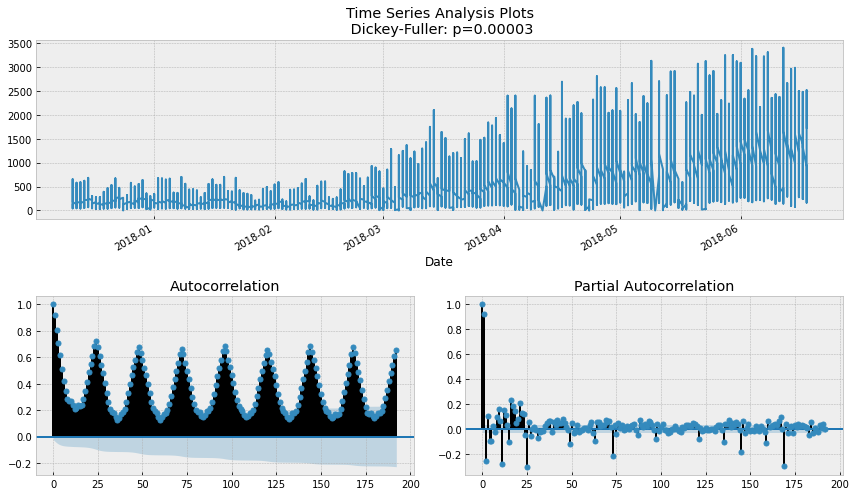

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df['Y'], lags=24*8)

D'après les graph d'autocorrelation, on remarque que les données temporelles sont périodique, on peut donc prendre en compte l'heure, le jour, la semaine.




In [ ]:
df = pd.DataFrame(sbdata.copy())

#change le format de la date et la passe en index
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace = True)
df.rename(columns={'Rented Bike Count': 'Y'}, inplace=True)

#on commence la dataset au premier lundi
df = df[datetime(2017,12,4):datetime(2017,12,4)+timedelta(7*4*7)]
#on ajoute du lag à 1h, un jour, et une semaine
df["lag_1"] = df['Y'].shift(1)
df["lag_24"] = df['Y'].shift(24)
df["lag_168"] = df['Y'].shift(24*7)

df['Holiday'] = [1 if x=='Holiday' else 0 for x in df['Holiday'] ]
df['Functioning Day'] = [1 if x=='Yes' else 0 for x in df['Functioning Day'] ]
df['Weekday'] = pd.Categorical(pd.Series(df.index).dt.day_name(), categories=['Monday', 'Tuesday', 
             'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Weekend'] = (df['Weekday'].cat.codes >= 5).astype(int)

#les données temporelles sont cycliques, on peut donc les insérer avec leur sin et cos
df['Hour_sin'] = np.sin(df['Hour']*(2.*np.pi/24))
df['Hour_cos'] = np.cos(df['Hour']*(2.*np.pi/24))
df['Weekday_sin'] = np.sin(df['Weekday'].cat.codes*(2.*np.pi/7))
df['Weekday_cos'] = np.cos(df['Weekday'].cat.codes*(2.*np.pi/7))
df.drop(['Hour', 'Seasons', 'Weekday'], axis=1, inplace=True)

#on enlève la première semaine pour éviter les NaN des lags
df = df.iloc[24*7:]
df.head()

,Y,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,lag_1,lag_24,lag_168,Weekend,Hour_sin,Hour_cos,Weekday_sin,Weekday_cos
Date,,,,,,,,,,,,,,,,,,,
2017-12-11,125,-2.5,39,3.4,2000,-14.5,0.0,0.0,0.0,0,1,148.0,326.0,285.0,0,0.000000,1.000000,0.0,1.0
2017-12-11,111,-3.4,36,3.8,2000,-16.3,0.0,0.0,0.0,0,1,125.0,280.0,186.0,0,0.258819,0.965926,0.0,1.0
2017-12-11,67,-4.2,35,3.4,2000,-17.4,0.0,0.0,0.0,0,1,111.0,243.0,112.0,0,0.500000,0.866025,0.0,1.0
2017-12-11,45,-4.7,38,2.4,2000,-16.8,0.0,0.0,0.0,0,1,67.0,169.0,65.0,0,0.707107,0.707107,0.0,1.0
2017-12-11,44,-5.2,35,3.2,2000,-18.3,0.0,0.0,0.0,0,1,45.0,71.0,41.0,0,0.866025,0.500000,0.0,1.0


In [ ]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

Troisième régression linéaire

In [ ]:
# Fit regression model
lr = LinearRegression().fit(X_train, Y_train)
lr.coef_

# Predict
Y_prediction = lr.predict(X_test)

score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.8766872087267614
mean_sqrd_error is== 41443.2287024777
root_mean_squared error of is== 203.57610051889122


Troisième regression tree

In [ ]:
# Fit regression model
regr = DecisionTreeRegressor(max_depth=10)
regr.fit(X_train, Y_train)

# Predict
Y_prediction = regr.predict(X_test)

score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.8902471884917479
mean_sqrd_error is== 36885.96147335399
root_mean_squared error of is== 192.05718282155968


On essaie la méthode du Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=12, random_state=0).fit(X_train, Y_train)
Y_prediction = regr.predict(X_test)
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


r2 score is  0.9593082690476251
mean_sqrd_error is== 13675.7646530133
root_mean_squared error of is== 116.94342500975975


On remarque une très nette amélioration du modèle. On souhaite à présent l'améliorer en optimisant les hyper paramètres.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]}
base_estimator = RandomForestRegressor(random_state=0)
sh = GridSearchCV(base_estimator, param_grid, cv=5).fit(X_train, Y_train)

Y_prediction = sh.predict(X_test)
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))
print(sh.best_estimator_)

La profondeur maximum recommandée est de 12.

Et un jour à l'avance

In [ ]:
X = np.concatenate((df.iloc[:, 1:11].values, df.iloc[:, 12:].values), axis=1)
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
# Fit regression model
lr = LinearRegression().fit(X_train, Y_train)
lr.coef_

# Predict
Y_prediction = lr.predict(X_test)

score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.7417315272176874
mean_sqrd_error is== 86799.42505267012
root_mean_squared error of is== 294.61742150231055


Et une semaine à l'avance

In [ ]:
X = np.concatenate((df.iloc[:, 1:11].values, df.iloc[:, 13:].values), axis=1)
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
# Fit regression model
lr = LinearRegression().fit(X_train, Y_train)
lr.coef_

# Predict
Y_prediction = lr.predict(X_test)

score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.7031015066252599
mean_sqrd_error is== 99782.28564371762
root_mean_squared error of is== 315.88334182688016


# TEST AVEC DEW POINT EN MOINS 

In [ ]:
df = pd.DataFrame(sbdata.copy())
del df['Dew point temperature(°C)']
#change le format de la date et la passe en index
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace = True)
df.rename(columns={'Rented Bike Count': 'Y'}, inplace=True)

#on commence la dataset au premier lundi
df = df[datetime(2017,12,4):datetime(2017,12,4)+timedelta(7*4*7)]
#on ajoute du lag à 1h, un jour, et une semaine
df["lag_1"] = df['Y'].shift(1)
df["lag_24"] = df['Y'].shift(24)
df["lag_168"] = df['Y'].shift(24*7)

df['Holiday'] = [1 if x=='Holiday' else 0 for x in df['Holiday'] ]
df['Functioning Day'] = [1 if x=='Yes' else 0 for x in df['Functioning Day'] ]
df['Weekday'] = pd.Categorical(pd.Series(df.index).dt.day_name(), categories=['Monday', 'Tuesday', 
             'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Weekend'] = (df['Weekday'].cat.codes >= 5).astype(int)

#les données temporelles sont cycliques, on peut donc les insérer avec leur sin et cos
df['Hour_sin'] = np.sin(df['Hour']*(2.*np.pi/24))
df['Hour_cos'] = np.cos(df['Hour']*(2.*np.pi/24))
df['Weekday_sin'] = np.sin(df['Weekday'].cat.codes*(2.*np.pi/7))
df['Weekday_cos'] = np.cos(df['Weekday'].cat.codes*(2.*np.pi/7))
df.drop(['Hour', 'Seasons', 'Weekday'], axis=1, inplace=True)

#on enlève la première semaine pour éviter les NaN des lags
df = df.iloc[24*7:]
df.head()

,Y,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Holiday,Functioning Day,lag_1,lag_24,lag_168,Weekend,Hour_sin,Hour_cos,Weekday_sin,Weekday_cos
Date,,,,,,,,,,,,,,,,,,
2017-12-11,125,-2.5,39,3.4,2000,0.0,0.0,0.0,0,1,148.0,326.0,285.0,0,0.000000,1.000000,0.0,1.0
2017-12-11,111,-3.4,36,3.8,2000,0.0,0.0,0.0,0,1,125.0,280.0,186.0,0,0.258819,0.965926,0.0,1.0
2017-12-11,67,-4.2,35,3.4,2000,0.0,0.0,0.0,0,1,111.0,243.0,112.0,0,0.500000,0.866025,0.0,1.0
2017-12-11,45,-4.7,38,2.4,2000,0.0,0.0,0.0,0,1,67.0,169.0,65.0,0,0.707107,0.707107,0.0,1.0
2017-12-11,44,-5.2,35,3.2,2000,0.0,0.0,0.0,0,1,45.0,71.0,41.0,0,0.866025,0.500000,0.0,1.0


matplotlib.axes._subplots.AxesSubplot

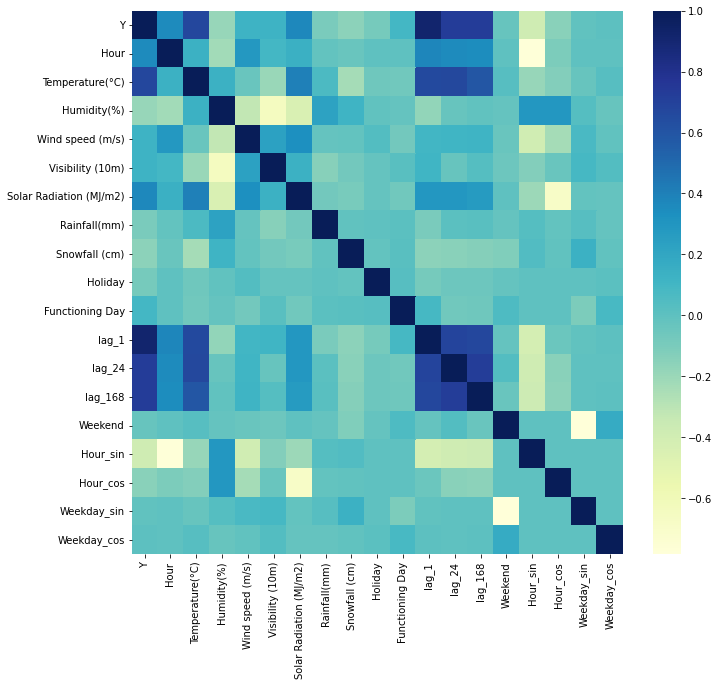

In [ ]:
fig, ax = plt.subplots(figsize=(11,10))
hmap = sns.heatmap(df.corr(),cmap="YlGnBu")
type(hmap)

In [ ]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Fit regression model
lr = LinearRegression().fit(X_train, Y_train)
lr.coef_

# Predict
Y_prediction = lr.predict(X_test)

score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

r2 score is  0.889656010623801
mean_sqrd_error is== 37084.64580554855
root_mean_squared error of is== 192.57374121501755


# Nouveau modèle :

In [ ]:
df = pd.DataFrame(sbdata.copy())


#ajout d'une colonne avec la moyenne de température de la saison correspondante
TW = df[df['Seasons']=="Winter"]['Temperature(°C)'].mean()
TSP = df[df['Seasons']=="Spring"]['Temperature(°C)'].mean()
TS = df[df['Seasons']=="Summer"]['Temperature(°C)'].mean()
TA = df[df['Seasons']=="Autumn"]['Temperature(°C)'].mean()
df.loc[df['Seasons'] =='Winter', 'TemperatureM'] = TW 
df.loc[df['Seasons'] =='Spring', 'TemperatureM'] = TSP
df.loc[df['Seasons'] =='Summer', 'TemperatureM'] = TS
df.loc[df['Seasons'] =='Autumn', 'TemperatureM'] = TA

index = df[df['Functioning Day']==0].index
df.drop(index, inplace=True)

del df['Dew point temperature(°C)']
#change le format de la date et la passe en index
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace = True)
df.rename(columns={'Rented Bike Count': 'Y'}, inplace=True)

#on commence la dataset au premier lundi
df = df[datetime(2017,12,4):datetime(2017,12,4)+timedelta(7*4*7)]
#on ajoute du lag à 1h, un jour, et une semaine
df["lag_1"] = df['Y'].shift(1)
df["lag_24"] = df['Y'].shift(24)
df["lag_168"] = df['Y'].shift(24*7)

df['Holiday'] = [1 if x=='Holiday' else 0 for x in df['Holiday'] ]
df['Functioning Day'] = [1 if x=='Yes' else 0 for x in df['Functioning Day'] ]
df['Weekday'] = pd.Categorical(pd.Series(df.index).dt.day_name(), categories=['Monday', 'Tuesday', 
             'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
df['Weekend'] = (df['Weekday'].cat.codes >= 5).astype(int)
#df['Hour'] = pd.Series(pd.Series(df.index).dt.hour.values, index= df.index)

#les données temporelles sont cycliques, on peut donc les insérer avec leur sin et cos
df['Hour_sin'] = np.sin(df['Hour']*(2.*np.pi/24))
df['Hour_cos'] = np.cos(df['Hour']*(2.*np.pi/24))
df['Weekday_sin'] = np.sin(df['Weekday'].cat.codes*(2.*np.pi/7))
df['Weekday_cos'] = np.cos(df['Weekday'].cat.codes*(2.*np.pi/7))
df.drop([ 'Seasons', 'Weekday', 'Humidity(%)','Visibility (10m)'], axis=1, inplace=True)

#on enlève la première semaine pour éviter les NaN des lags
df = df.iloc[24*7:]

matplotlib.axes._subplots.AxesSubplot

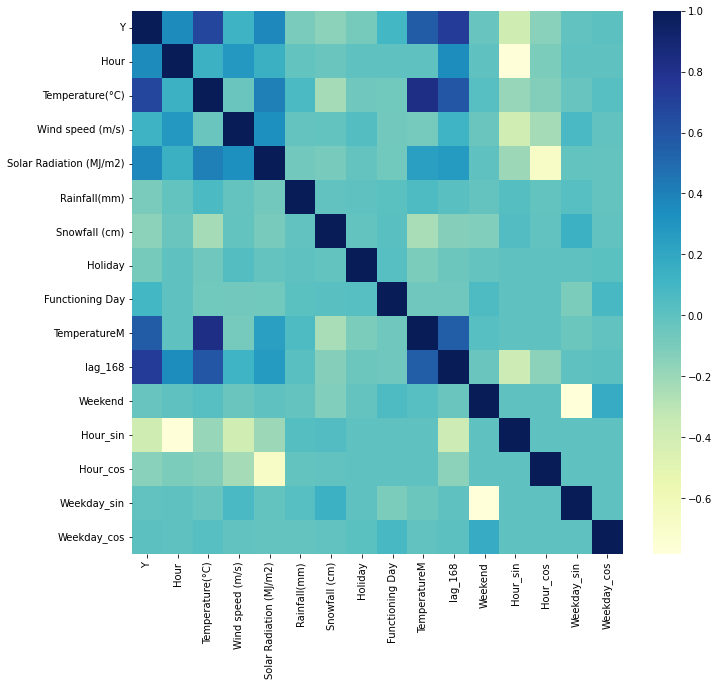

In [ ]:
fig, ax = plt.subplots(figsize=(11,10))
hmap = sns.heatmap(df.corr(),cmap="YlGnBu")
type(hmap)

In [ ]:
X = df.iloc[:, 1:].values
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
regr = RandomForestRegressor(max_depth=12, random_state=0).fit(X_train, Y_train)
Y_prediction = regr.predict(X_test)
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


r2 score is  0.9613766422490039
mean_sqrd_error is== 12980.621328936926
root_mean_squared error of is== 113.93252972236212


In [ ]:
X = np.concatenate((df.iloc[:, 1:11].values, df.iloc[:, 12:].values), axis=1)
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
regr = RandomForestRegressor(max_depth=12, random_state=0).fit(X_train, Y_train)
Y_prediction = regr.predict(X_test)
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


r2 score is  0.9610749420764579
mean_sqrd_error is== 13082.017373266937
root_mean_squared error of is== 114.37664697510125


In [ ]:
X = np.concatenate((df.iloc[:, 1:11].values, df.iloc[:, 13:].values), axis=1)
Y = df.iloc[:, [0]].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

In [ ]:
regr = RandomForestRegressor(max_depth=12, random_state=0).fit(X_train, Y_train)
Y_prediction = regr.predict(X_test)
score = r2_score(Y_test, Y_prediction)
print("r2 score is ", score)
print("mean_sqrd_error is==", mean_squared_error(Y_test, Y_prediction))
print("root_mean_squared error of is==", np.sqrt(mean_squared_error(Y_test, Y_prediction)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


r2 score is  0.9601827206275986
mean_sqrd_error is== 13381.87708105997
root_mean_squared error of is== 115.68006345546311


On obtient à présent une précision à 96% même une semaine à l'avance.